# Chargement données d'entrainement

In [1]:
# Chargement de la librairie
from fastai2.vision.all import *

# Récupération des images
path = Path('/storage/data/mnist_sample')
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
three_tensor = [tensor(Image.open(o)) for o in threes]
seven_tensor = [tensor(Image.open(o)) for o in sevens]

# On ramène les valeurs entre 0 et 255 à leur équivalent entre 0 et 1. 
# On simplifie la liste pour obtenir une liste ??
stacked_threes = torch.stack(three_tensor).float()/255
stacked_sevens = torch.stack(seven_tensor).float()/255

# On regroupe ces informations dans un seul tensor
# On crée également un tensor avec les valeur attendues (1 c'est un trois, 0 ce n'est pas un trois)
stacked_digits = torch.cat([stacked_threes, stacked_sevens])
stacked_labels = tensor([1]*len(threes) + [0]*len(sevens))

# On transforme les tableaux de 28 par 28 pixel en une liste de 784 pixels pour simplifier le traitement 
# On formate les deux tensors pour être équivalent 
train_x = stacked_digits.view(-1, 28*28)
train_y = stacked_labels.unsqueeze(1)
train_dataset = list(zip(train_x,train_y))

# On met en batch 
train_dl = DataLoader(train_dataset,batch_size=256)

# Chargement données de validation

In [2]:
# On charge les images valides. 
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

# On concatène et crée la liste de label
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dataset = list(zip(valid_x,valid_y))

#On met en batch
valid_dl = DataLoader(valid_dataset, batch_size=256)

# Regroupement des données 

In [3]:
dls = DataLoaders(train_dl,valid_dl)

# Définition des méthodes

### Calcul de cout (loss function)

In [4]:
# On utilise le sigmoid pour ramener le résultat obtenu par le model à sa valeur entre 0 et 1
# On renvoit la moyenne des distances d'erreur
def mnist_loss(activations_01, targets):
        activations_01 = activations_01.sigmoid()
        distances = torch.where(targets==1,1-activations_01,activations_01)
        return distances.mean()

### Calcul de la performance 

In [5]:
# On calcul le nombre de prédictions correctes 
def accuracy(activations, targets):
    predictions = activations > 0
    corrects = (predictions == targets)
    return corrects.float().mean()

### Calcul du gradient

In [6]:
# On applique le model puis on appel backward (propagation) pour calculer l'ensemble des gradients
def compute_gradient(xb, yb, model, loss_func): 
    predictions = model(xb)
    loss = loss_func(predictions, yb)
    loss.backward()

# Les classes 

### Gestion des gradients 

In [7]:
class SGDOptimizer: 
    
    def __init__(self,model,lr):
        self.params = list(model.params)
        self.lr = lr

    # On modifie chaque paramètre en fonction du gradient et du learning rate défini
    def adjust_params(self):
        for param_tensor in self.params:
            param_tensor.data -= param_tensor.grad.data * self.lr  
            
    # remise à zéros du gradient pour itération suivante. 
    def zero_grad(self):
        for param_tensor in self.params:
            param_tensor.grad.zero_()

### Le model

In [8]:
class LinearModel:
    
    @staticmethod
    def init_params(size):
        return torch.randn(size).requires_grad_()
    
    # Initialisation des paramètres remplace init_params
    def __init__(self):
        self.params = (LinearModel.init_params(28*28), LinearModel.init_params(1))
    
    # Application du model remplace linear_model
    def __call__(self, inputs):
        weights,bias = self.params
        return inputs@weights + bias
    
    # Le self() va déclencher le __call__()
    def predict(self,inputs):
        activations = self(inputs)
        return activations > 0

# Les méthodes d'époque

In [9]:
# On parcours les mini-batch et on va calculer les gradients puis appliquer la learning rate sur chaque paramètre
def train_epoch(train_dl, model, loss_func, optim):
    for xb, yb in train_dl:
        compute_gradient(xb,yb,model,loss_func)
        optim.adjust_params() # On modifie chaque paramètre en fonction du gradient et du learning rate défini
        optim.zero_grad() # remise à zéros du gradient pour itération suivante. 

def compute_metric(xb, yb, model, metric):
    activations = model(xb)
    return metric(activations, yb)
        
# On parcours les mini batchs du dataset de validation et on calcule le taux de réussite avec le model actuel. 
# On retourne la moyenne de ces taux de réussite
def validate_epoch(valid_dl, model, metric):
        perfs = [compute_metric(xb, yb, model, metric) for xb,yb in valid_dl]
        return round(torch.stack(perfs).mean().item(), 4)

# La méthode d'entrainement

In [10]:
def train_model(dls, model, loss_func, metric, optim, epochs):
    for i in range(epochs):
        train_epoch(dls.train, model, loss_func, optim)
        print(validate_epoch(dls.valid, model, metric), end=' ')

# Execution

In [11]:
model = LinearModel()
sgd = SGDOptimizer(model, lr=1)

train_model(dls, model, loss_func=mnist_loss, metric=accuracy, optim=sgd, epochs=40)

0.6142 0.816 0.906 0.9286 0.9389 0.9465 0.9511 0.9521 0.9545 0.9555 0.9559 0.9579 0.9579 0.9584 0.9594 0.9598 0.9598 0.9598 0.9598 0.9608 0.9608 0.9608 0.9608 0.9613 0.9617 0.9632 0.9637 0.9637 0.9637 0.9642 0.9642 0.9642 0.9652 0.9652 0.9647 0.9642 0.9647 0.9647 0.9657 0.9657 

# Méthodes Framework

In [14]:
# nn.Linear est l'équivalent de notre model linéaire. SGD l'équivalent de notre Optimiseur
# Learner est l'objet de base pour regrouper le tout.
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=accuracy)

In [15]:
# Revient à un appel de notre train_model.
learn.fit(10, lr=1.)

epoch,train_loss,valid_loss,accuracy,time
0,0.637096,0.503325,0.495584,00:00
1,0.473746,0.210929,0.814033,00:00
2,0.175497,0.168145,0.850834,00:00
3,0.077805,0.102601,0.914132,00:00
4,0.041864,0.075889,0.933268,00:00
5,0.027831,0.061218,0.949460,00:00
6,0.022047,0.052023,0.956820,00:00
7,0.019457,0.045877,0.962218,00:00
8,0.018128,0.041531,0.965162,00:00
9,0.017318,0.038301,0.967125,00:00


# Réseau de neurones

epoch,train_loss,valid_loss,accuracy,time
0,0.309987,0.417313,0.504416,00:00
1,0.146469,0.229161,0.806673,00:00
2,0.081131,0.115359,0.917076,00:00
3,0.053340,0.078120,0.939156,00:00
4,0.040452,0.061025,0.954858,00:01
5,0.033854,0.051374,0.963690,00:00


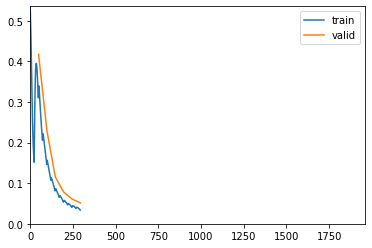

In [ ]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30), # Production de 30 combinaisons linéaires différentes des 28*28 paramètres d'entrée (23 550 paramètres à ajuster)
    nn.ReLU(), # Ajout d'une non linéarité (création de "segments de droite" à combiner)
    nn.Linear(30,1)) # combinaison linéaire des 30 valeurs intermédiaires pour produire une prédiction (31 paramètres à ajuster)

learn = Learner(dls, simple_net, opt_func=SGD,
               loss_func=mnist_loss, metrics=accuracy,
               cbs=ShowGraphCallback())

learn.fit(40, 0.1)